In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import re as re
from collections import Counter






In [2]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from tqdm.auto import tqdm
import math
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier

In [4]:
from xgboost import plot_tree as xgb_plot_tree
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc


from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform


In [20]:
import warnings
warnings.filterwarnings('ignore')

import time
from xgboost import XGBClassifier
%matplotlib inline
tqdm.pandas()

# rc = {
#     "axes.facecolor": "#FFEDED",
#     "figure.facecolor": "#FFEDED",
#     "axes.edgecolor": "#000000",
#     "grid.color": "#EBEBE7",
#     "font.family": "serif",
#     "axes.labelcolor": "#000000",
#     "xtick.color": "#000000",
#     "ytick.color": "#000000",
#     "grid.alpha": 0.4
# }

# font = {'family': 'serif',
#         'color':  'black',
#         'weight': 'bold',
#         'size': 16,
#         }

# sns.set(rc=rc)

# from colorama import Style, Fore
# red = Style.BRIGHT + Fore.RED
# blu = Style.BRIGHT + Fore.BLUE
# mgt = Style.BRIGHT + Fore.MAGENTA
# gld = Style.BRIGHT + Fore.YELLOW
# res = Style.RESET_ALL
# bold_start = Style.BRIGHT
# bold_end = Style.NORMAL

In [6]:
def describe(df):
    print(f'{bold_start}Data shape : {bold_end}{red}{df.shape}{res}')
    print(f'{bold_start}____________________________________________________________________{bold_end}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['missing_#'] = df.isnull().sum().values 
    summ['missing_%'] = df.isnull().sum().values / len(df) * 100
    summ['unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['mean'] = desc['mean'].values
    summ['std'] = desc['std'].values
    summ['min'] = desc['min'].values
    summ['25%'] = desc['25%'].values
    summ['50%'] = desc['50%'].values
    summ['75%'] = desc['75%'].values
    summ['max'] = desc['max'].values
    summ['1st'] = df.loc[0].values
    summ['2nd'] = df.loc[1].values
    summ['3rd'] = df.loc[2].values
    
    return summ


In [7]:
def plot_count(df: pd.core.frame.DataFrame, col_list: list, title_name: str='Train') -> None:
    f, ax = plt.subplots(len(col_list), 2, figsize=(12, 5))
    plt.subplots_adjust(wspace=0.3)

    for col in col_list:
        s1 = df[col].value_counts()
        N = len(s1)
        outer_sizes = s1
        inner_sizes = s1/N
        outer_colors = ['#FF6347', '#20B2AA']
        inner_colors = ['#FFA07A', '#40E0D0']

        ax[0].pie(
            outer_sizes, colors=outer_colors, 
            labels=s1.index.tolist(), 
            startangle=90, frame=True, radius=1.2, 
            explode=([0.05]*(N-1) + [.2]),
            wedgeprops={'linewidth': 1, 'edgecolor': 'white'}, 
            textprops={'fontsize': 14, 'weight': 'bold'},
            shadow=True
        )

        ax[0].pie(
            inner_sizes, colors=inner_colors,
            radius=0.8, startangle=90,
            autopct='%1.f%%', explode=([.1]*(N-1) + [.2]),
            pctdistance=0.8, textprops={'size': 13, 'weight': 'bold', 'color': 'black'},
            shadow=True
        )

        center_circle = plt.Circle((0,0), .5, color='black', fc='white', linewidth=0)
        ax[0].add_artist(center_circle)
        sns.barplot(
            x=s1, y=s1.index, ax=ax[1],
            palette='coolwarm', orient='horizontal'
        )

        ax[1].spines['top'].set_visible(False)
        ax[1].spines['right'].set_visible(False)
        ax[1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
        ax[1].set_ylabel('')  # Remove y label
        ax[1].bar_label(ax[1].containers[0], color='black', fontweight='bold', fontsize=14)

        plt.setp(ax[1].get_yticklabels(), fontweight="bold")
        plt.setp(ax[1].get_xticklabels(), fontweight="bold")
        ax[1].set_xlabel(col, fontweight="bold", color='black', fontsize=14)

    f.suptitle(f'{title_name} Dataset Distribution of {col}', fontsize=20, fontweight='bold', y=1.05)
    plt.tight_layout()    
    plt.show()

In [8]:
def plot_dist(df: pd.core.frame.DataFrame, col_list: list, target: str, title_name: str='Train') -> None:
    f, ax = plt.subplots(len(col_list), 2, figsize=(12, 5))
    plt.subplots_adjust(wspace=0.3)

    for col in col_list:
        ax[0] = sns.histplot(x=col, hue=target, data=df, bins=30, kde=True, palette='Reds')
        ax[1] = sns.boxplot(x=target, y=col, data=data)

    f.suptitle(f'{title_name} Dataset Distribution of {col}', fontsize=20, fontweight='bold', y=1.05)
    plt.tight_layout()    
    plt.show()

In [9]:
def plot_correlation_heatmap(df: pd.core.frame.DataFrame, order:str='target', title_name: str='Train correlation') -> None:
    corr = df.corr()
    fig, axes = plt.subplots(figsize=(12, 8))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, linewidths=.5, cmap='RdBu_r', annot=True, annot_kws={"size": 8})
    plt.title(title_name, fontsize=20, fontweight='bold', y=1.05)
    plt.show()

In [10]:
def perform_hierarchical_clustering(input_data, title):
    correlation_matrix = input_data.corr()
    distance_matrix = 1 - np.abs(correlation_matrix)
    Z = linkage(squareform(distance_matrix), 'complete')
    fig, ax = plt.subplots(1, 1, figsize=(14, 8), dpi=120)
    dn = dendrogram(Z, labels=input_data.columns, ax=ax, above_threshold_color='#ff0000', orientation='right', color_threshold=0.7*max(Z[:,2]))
    hierarchy.set_link_color_palette(None)  # Reset color palette to default
    plt.grid(axis='x')
    plt.title(f'{title} Hierarchical clustering, Dendrogram', fontsize=20, fontweight='bold', y=1.05)
    plt.show()

In [24]:
data = pd.read_csv(r"C:\Users\darshini\Downloads\archive\heart.csv")
data.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [25]:
describe(data)

Data shape : (303, 14)
____________________________________________________________________


,data type,missing_#,missing_%,unique,mean,std,min,25%,50%,75%,max,1st,2nd,3rd
age,int64,0,0.0,41,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0,63.0,37.0,41.0
sex,int64,0,0.0,2,0.683168,0.466011,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
cp,int64,0,0.0,4,0.966997,1.032052,0.0,0.0,1.0,2.0,3.0,3.0,2.0,1.0
trtbps,int64,0,0.0,49,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0,145.0,130.0,130.0
chol,int64,0,0.0,152,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0,233.0,250.0,204.0
fbs,int64,0,0.0,2,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
restecg,int64,0,0.0,3,0.528053,0.525860,0.0,0.0,1.0,1.0,2.0,0.0,1.0,0.0
thalachh,int64,0,0.0,91,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0,150.0,187.0,172.0
exng,int64,0,0.0,2,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
oldpeak,float64,0,0.0,40,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2,2.3,3.5,1.4


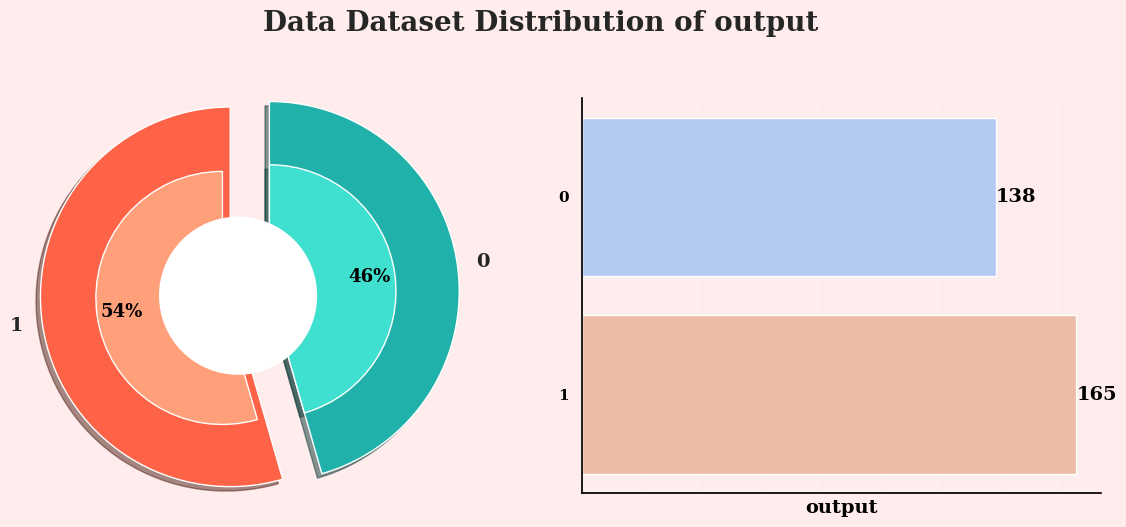

In [26]:
plot_count(data, ['output'], 'Data')

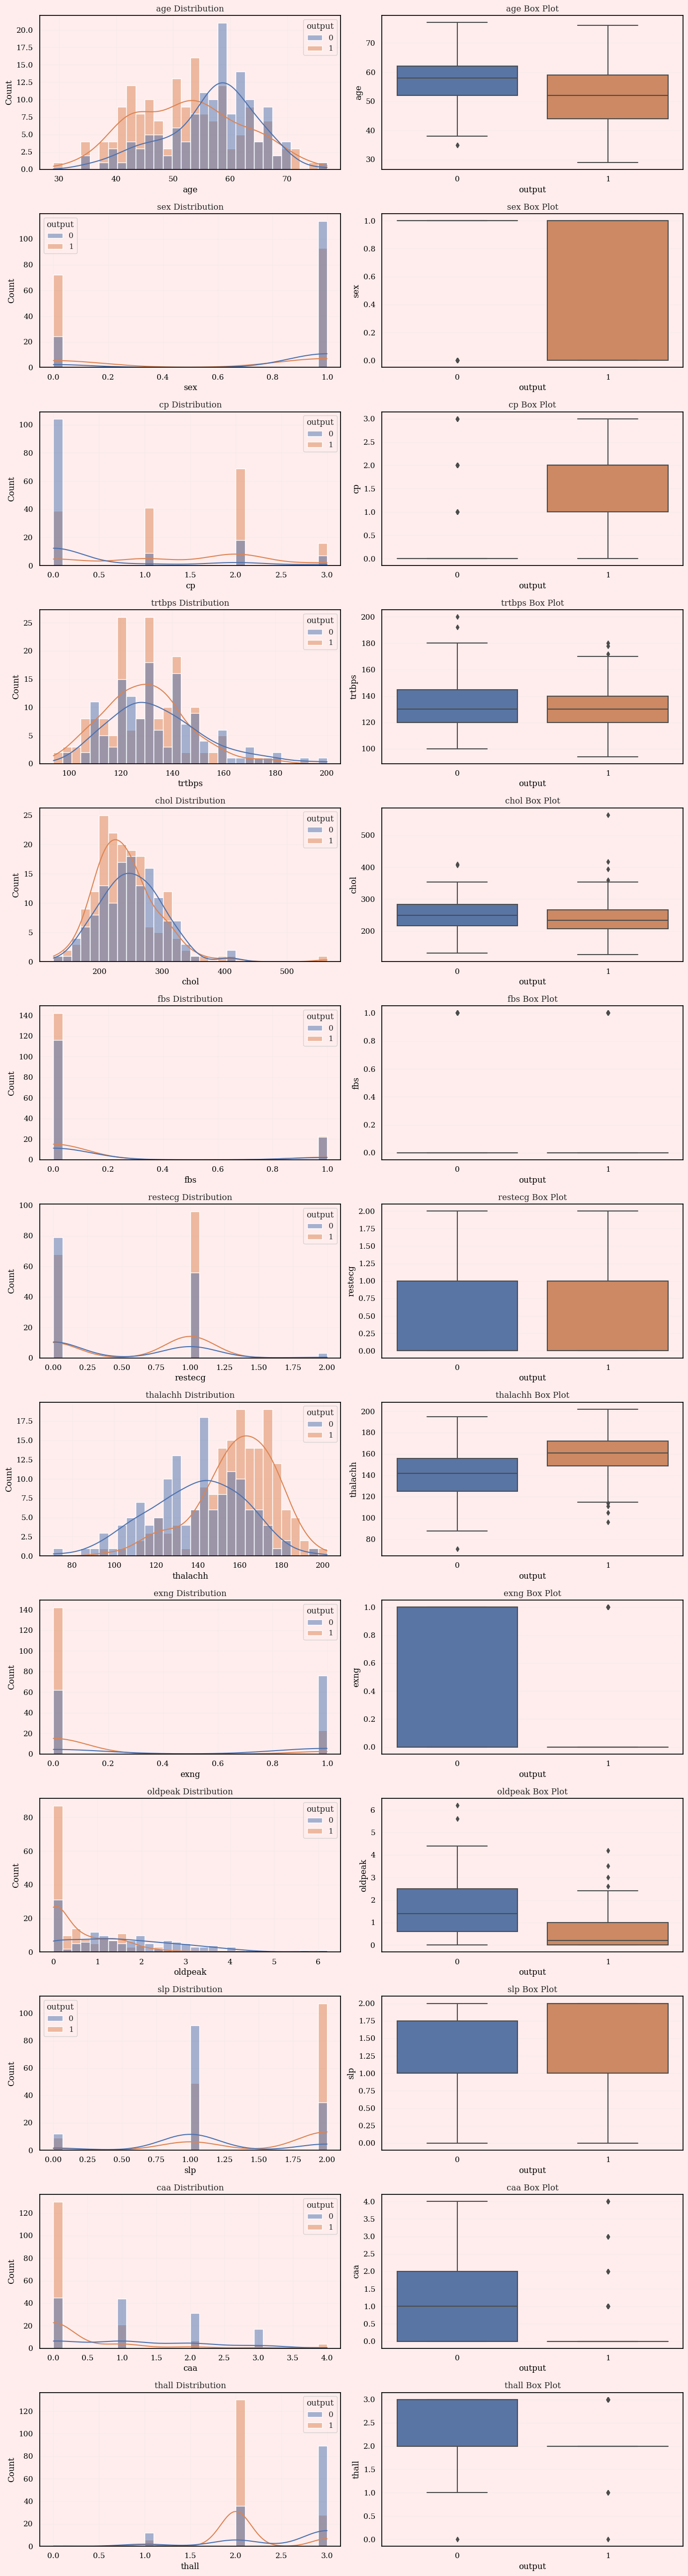

In [28]:
num_variables = data.select_dtypes(include=[np.number]).columns.tolist()
num_variables.remove('output')

fig, ax = plt.subplots(len(num_variables), 2, figsize=(14, len(num_variables)*4))

for idx, column in enumerate(num_variables):
    sns.histplot(x=column, hue="output", data=data, bins=30, kde=True,ax=ax[idx,0])
    ax[idx,0].set_title(f"{column} Distribution")
    
    sns.boxplot(x='output', y=column, data=data, ax=ax[idx,1])
    ax[idx,1].set_title(f"{column} Box Plot")
    
plt.tight_layout() 
plt.show()

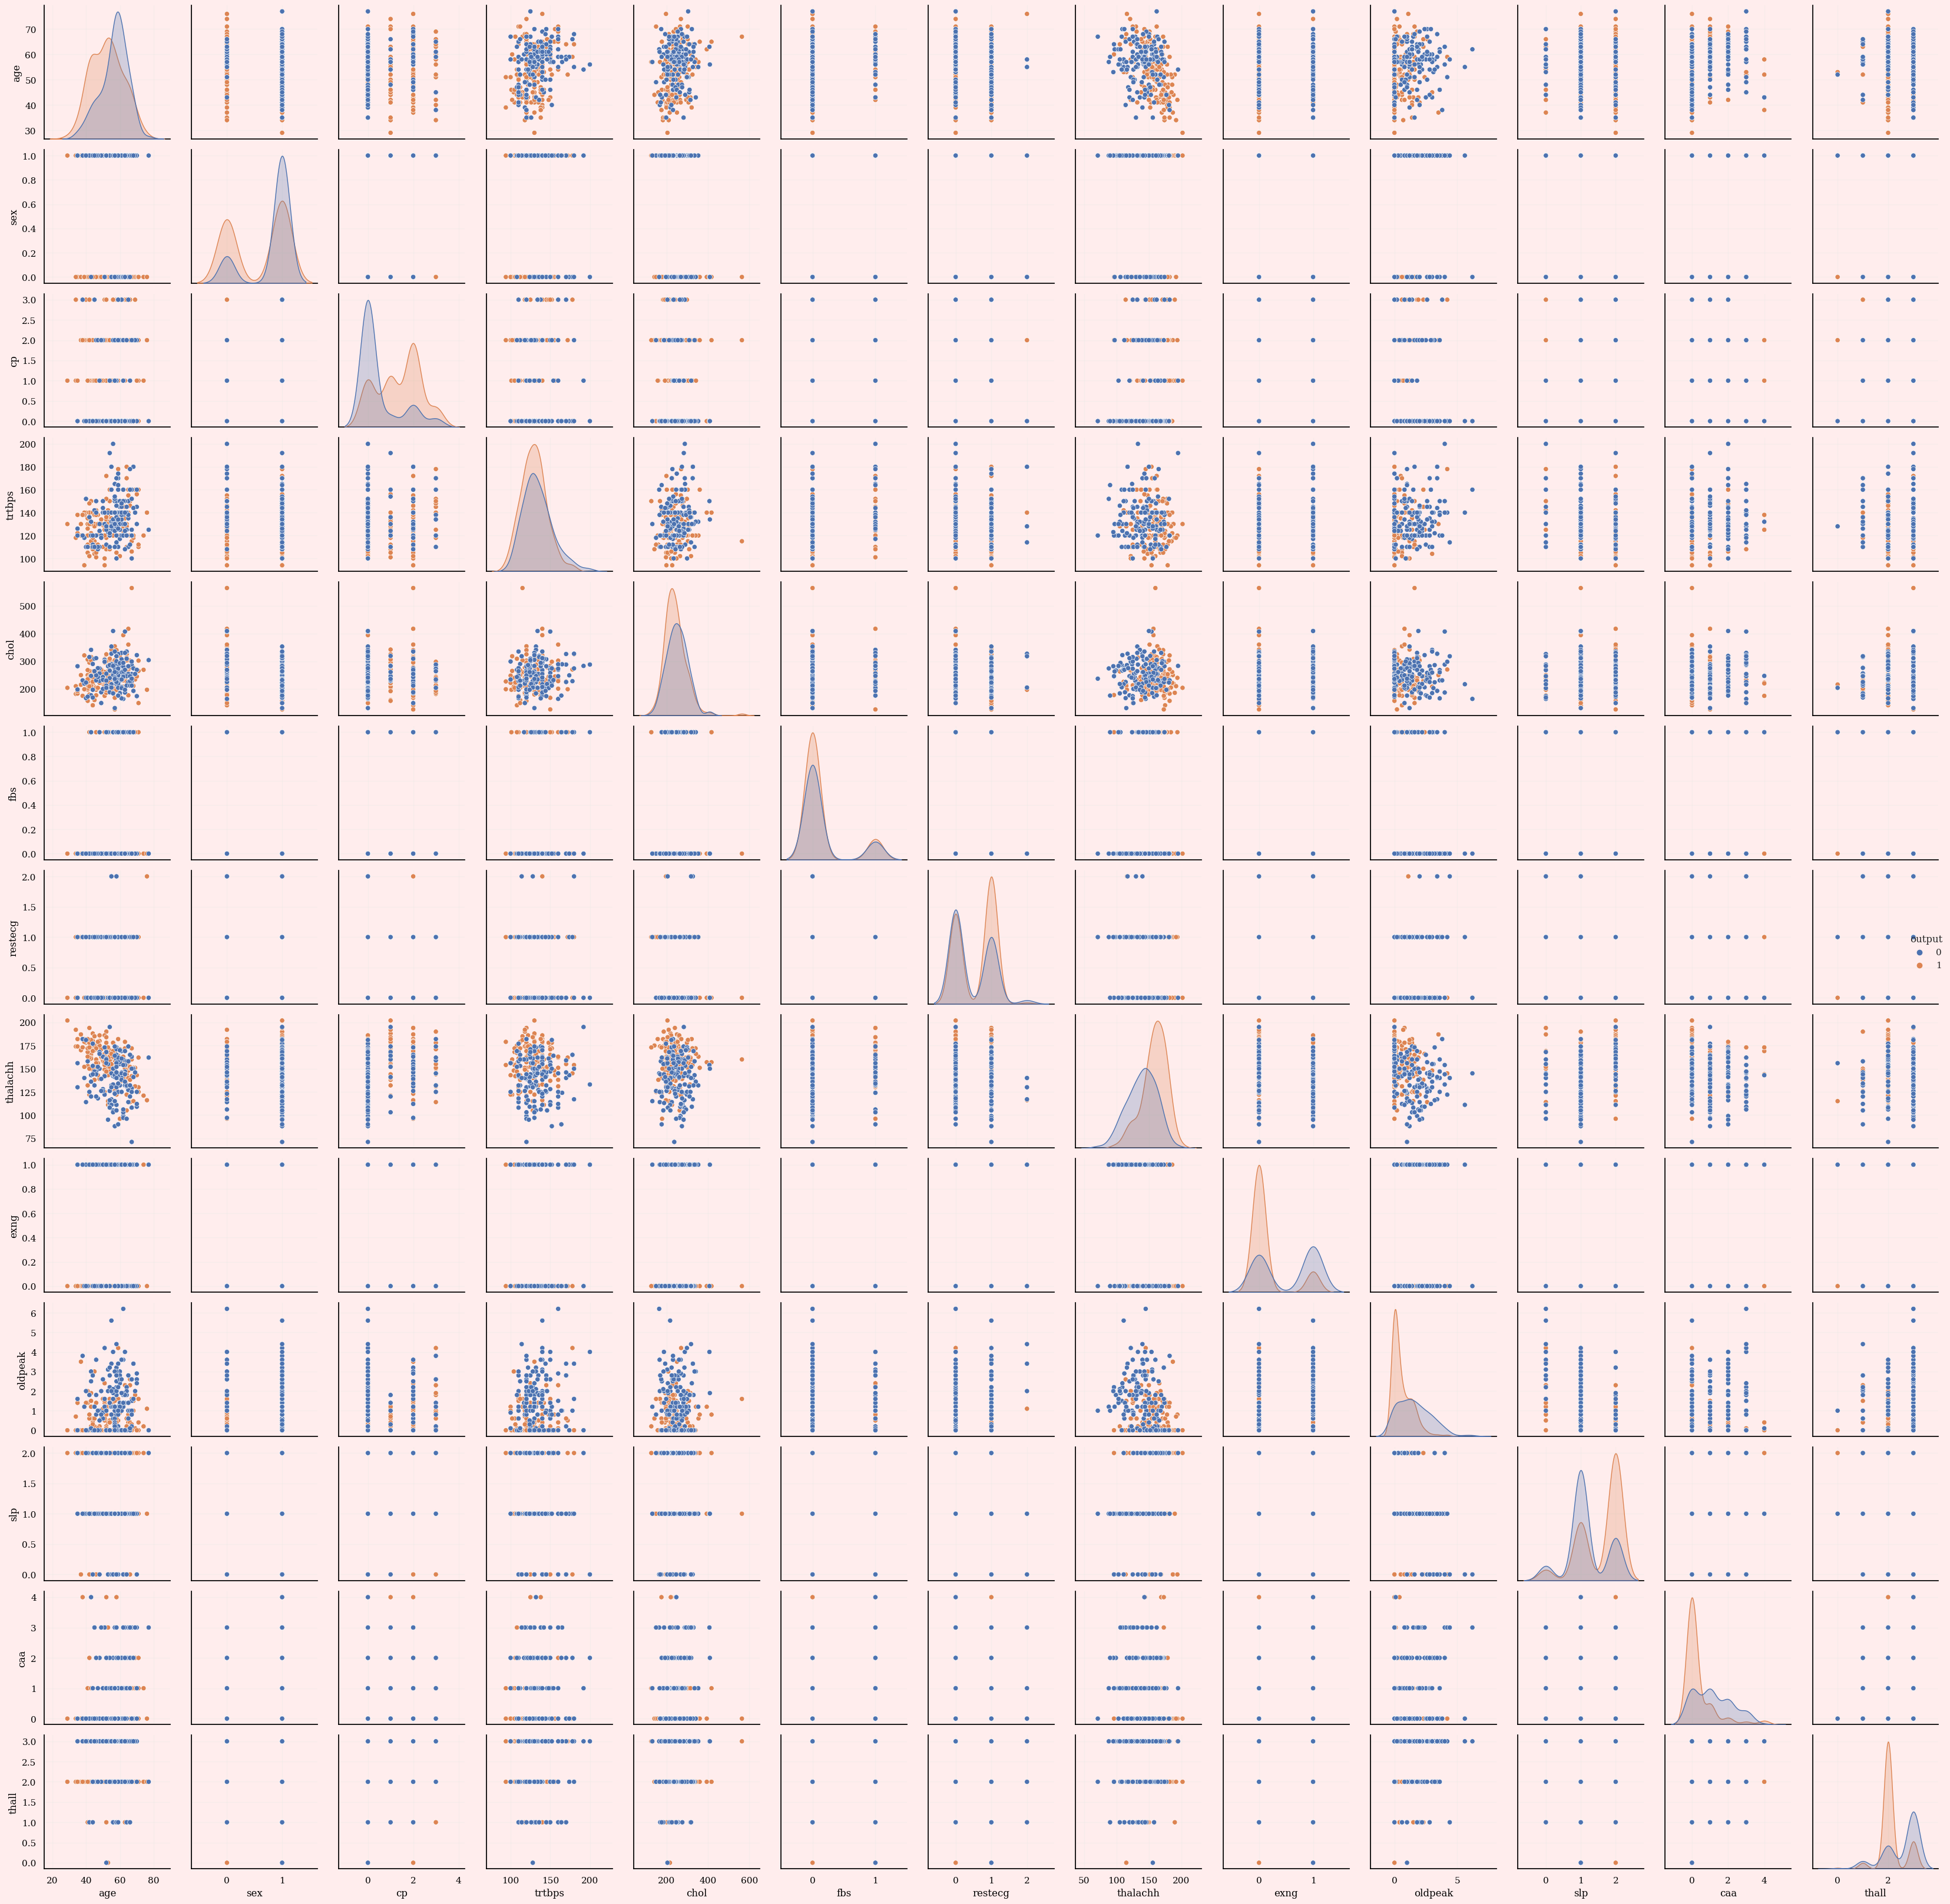

In [29]:
sns.pairplot(data, hue='output')
plt.tight_layout()
plt.show()

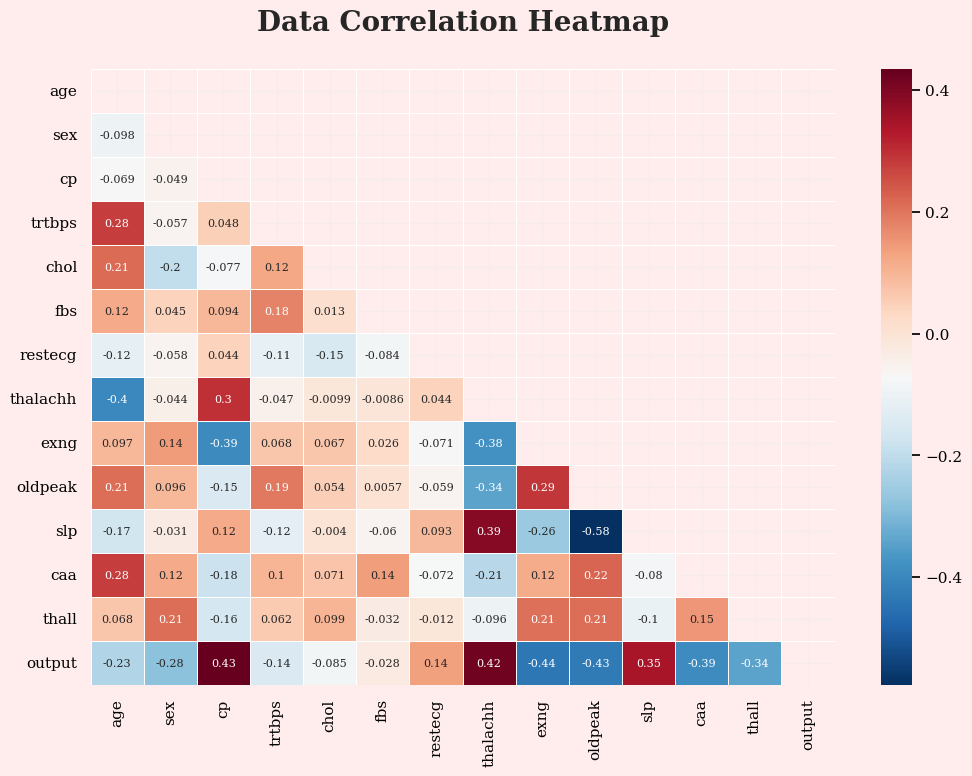

In [16]:
plot_correlation_heatmap(data, 'output', 'Data Correlation Heatmap')

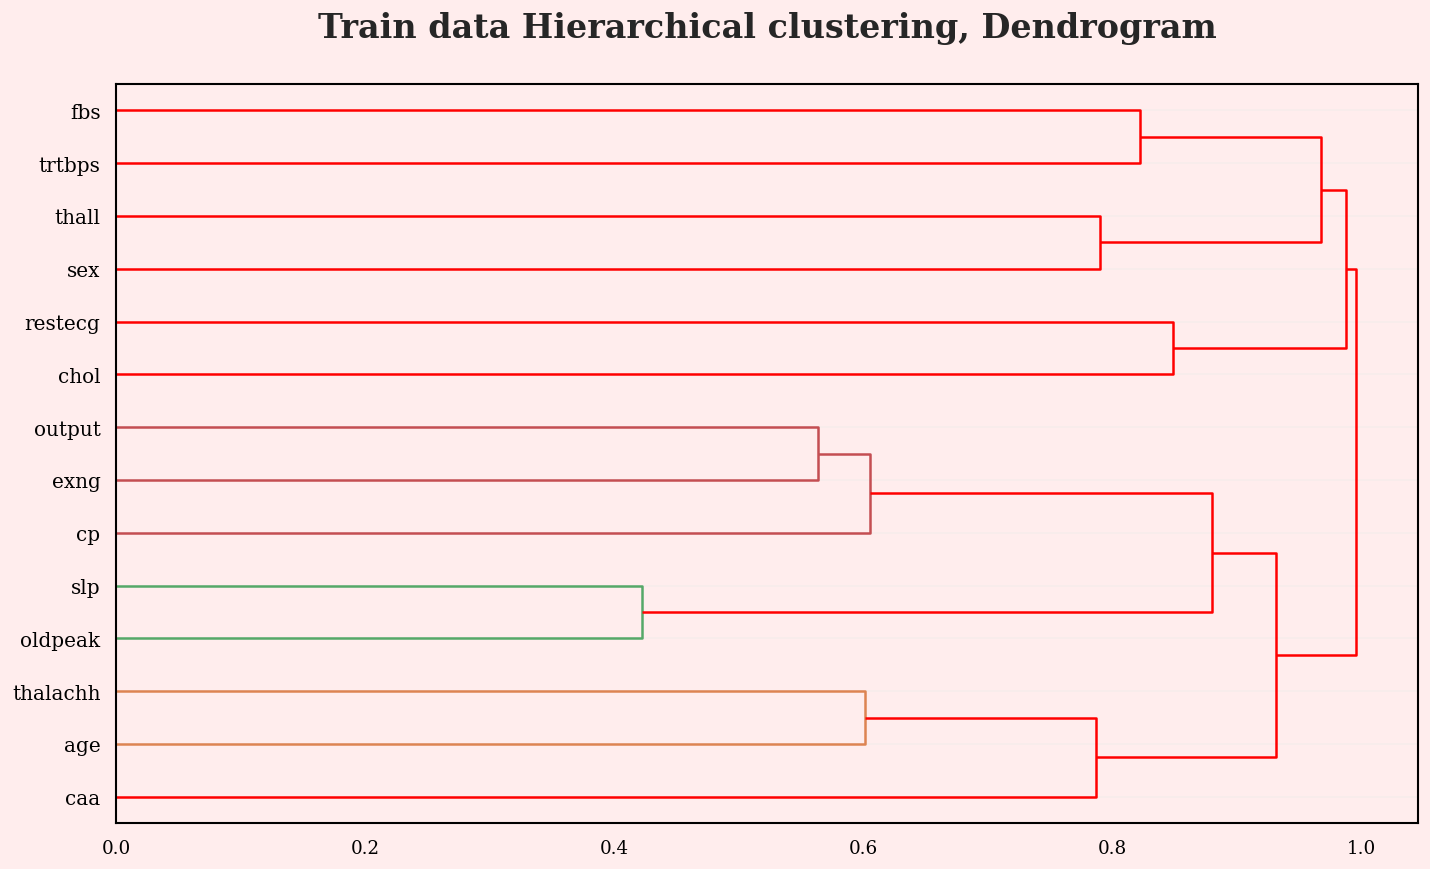

In [17]:
perform_hierarchical_clustering(data, title='Train data')